In [1]:
!pip install hydra-core --upgrade
!pip install rootutils
!pip install --upgrade pyDOE
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=b490d6dac88e44baf59062b455a587d91186b5e9b2604cf2a87e773cc975e1b4
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 21.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s e

In [2]:
import sys
# paths for Github link
package_paths = [
    '/kaggle/input/pdesolver/',
    '/kaggle/input/custompinnstorch/'
]

for pth in package_paths:
    sys.path.append(pth)

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
from typing import Dict
import torch
import random
import lightning.pytorch as pl
# import the solver
from Euler_IMEX import solve_E_I
# import Physics-Informed Neural Networks library in Pytorch
import pinnstorch

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
# clear output
#!rm -rf /kaggle/working/*

In [6]:
m = 400 # discretization for x
n = 7000 # discretization for t
x_disc = np.linspace(-1,1,m+1)
t_disc = np.linspace(0,0.1,n+1)
delta_x = (x_disc[-1] - x_disc[0])/(len(x_disc)-1)
delta_t = (t_disc[-1] - t_disc[0])/(len(t_disc)-1)
print(f"Δx = {delta_x}")
print(f"Δx**2 = {(delta_x)**2}")
print(f"Δt = {delta_t}")

Δx = 0.005
Δx**2 = 2.5e-05
Δt = 1.4285714285714287e-05


In [7]:
c = 1
sigma = 4
eps = 1e-4
rho_0 = 6+3*np.cos(3*np.pi*x_disc)
j_0 = (9*np.pi*(c**2)/sigma)*np.sin(3*np.pi*x_disc)

In [8]:
rho_tot, j_tot = solve_E_I(x_disc, t_disc, rho_0, j_0, eps, sigma, c)

In [9]:
T, X = np.meshgrid(t_disc, x_disc)

Since

$\rho = f^+ + f^-$ and $j = \frac{c}{\epsilon}(f^+ - f^-),$

then we have that $\,f^- = \frac{1}{2}(\rho - \frac{\epsilon}{c}j)$ and $f^+ = \rho - f^-.$

In [10]:
f_minus_tot = 0.5*(rho_tot - (eps*j_tot)/c)
f_plus_tot = rho_tot - f_minus_tot

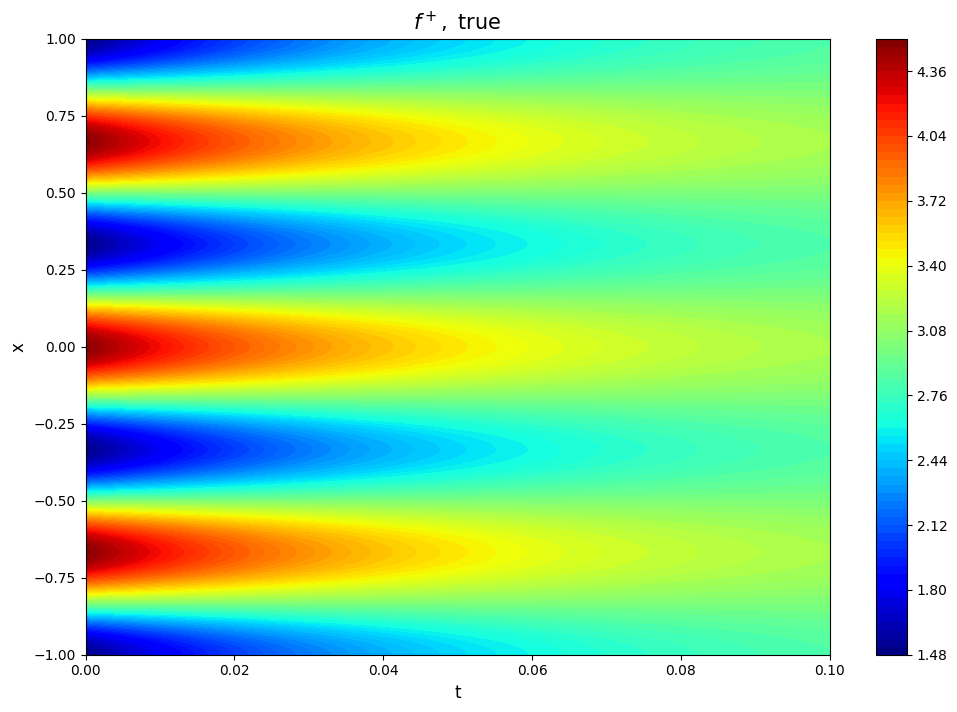

In [11]:
# f_plus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_plus_tot, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^+,$ true',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_plus.jpg', dpi=300)

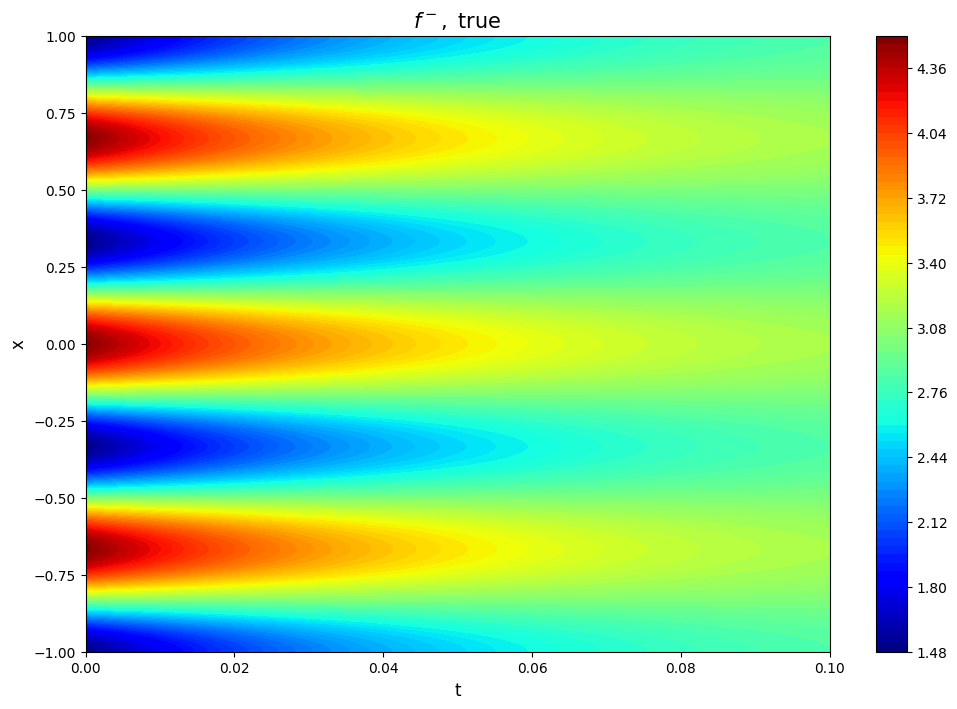

In [12]:
# f_minus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_minus_tot, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^-,$ true',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_minus.jpg', dpi=300)

In [13]:
mdic = {"f_plus": f_plus_tot, "f_minus": f_minus_tot, "x": x_disc, "tt": t_disc}
savemat("GT.mat", mdic)

In [14]:
def read_data_fn(root_path):

    """Read and preprocess data from the specified root path.



    :param root_path: The root directory containing the data.

    :return: Processed data will be used in PointCloud class.

    """



    data = pinnstorch.utils.load_data(root_path, "GT.mat")



    x = data["x"].T  # N x 1

    t = data["tt"].T  # T x 1


    exact_f_plus = data["f_plus"] # N x T

    exact_f_minus = data["f_minus"] # N x T



    return pinnstorch.data.PointCloudData(

            spatial=[x], time=[t], solution={"f_plus": exact_f_plus, "f_minus": exact_f_minus}

    )

In [15]:
mesh = pinnstorch.data.PointCloud(root_dir='/kaggle/working/',

                                  read_data_fn=read_data_fn)

#### Initial Condition



Let's start with initial condition of the model.

$$ \rho(x,\, 0) = 6 + 3\cos(3\pi x)$$

$$ j(x,\, 0) = \frac{9\pi c^2}{\sigma}\sin(3\pi x) $$

$$\,f^- = \frac{1}{2}(\rho - \frac{\epsilon}{c}j)$$

$$f^+ = \rho - f^-$$



For defining initial condition, again we have two options.



- **Sample from the data.**

- **Defining a function for calculating initial condition.**

In [16]:
N0 = 200

In [17]:
in_c = pinnstorch.data.InitialCondition(mesh = mesh,

                                        num_sample = N0,

                                        solution = ['f_plus', 'f_minus'])

The `pinnstorch.data.PeriodicBoundaryCondition` is used to sample periodic points from the upper and lower bounds of the spatial domain (mesh). The `derivative_order` parameter specifies the order of the derivative to be matched at these boundaries. In our case, for the Goldstein Taylor equation, both the function and its first spatial derivative should match at the boundaries, hence `derivative_order = 1`.





$$ f^+(-1,t) = f^+(1, t), $$

$$ f^-(-1, t) = f^-(1, t), $$

$$ f_{x}^+(-1, t) = f_{x}^+(1, t),$$

$$ f_{x}^-(-1, t) = f_{x}^-(1, t) $$

In [18]:
N_b = 3000

pe_b = pinnstorch.data.PeriodicBoundaryCondition(mesh = mesh,

                                                 num_sample = N_b,

                                                 derivative_order = 1,

                                                 solution = ['f_plus', 'f_minus'])

#### Mesh Sampler for collection points and solutions



In our problem, the partial differential equations (PDEs) governing the dynamics are given by:



$$f_{f^+} = \partial_{t}f^+ +\frac{c}{\epsilon}\partial_{x}f^+ + \frac{\sigma}{2\epsilon^2}(f^+ - f^-)$$

$$f_{f^-} = \partial_{t}f^- -\frac{c}{\epsilon}\partial_{x}f^- + \frac{\sigma}{2\epsilon^2}(f^- - f^+)$$


To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnstorch.data.MeshSampler` for this purpose, specifying the following:



- **Number of Sample Points (N_f):** We choose to sample 25,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.

- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.

- **Collection Points:** We define `['f_f_plus', 'f_f_minus']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.



Here's the code to implement this sampler:

In [19]:
N_f = 25000

me_s = pinnstorch.data.MeshSampler(mesh = mesh,

                                   num_sample = N_f,

                                   collection_points = ['f_f_plus', 'f_f_minus'])

me_s2 = pinnstorch.data.MeshSampler(mesh = mesh,

                                   num_sample = N_f,

                                   solution =  ['f_plus', 'f_minus'])

In [20]:
val_s = pinnstorch.data.MeshSampler(mesh = mesh,

                                    solution = ['f_plus', 'f_minus'])

In [21]:
net = pinnstorch.models.FCN(layers = [2, 100, 100, 100, 2],

                            output_names = ['f_plus', 'f_minus'],

                            lb=mesh.lb,

                            ub=mesh.ub)

In [22]:
def pde_fn(outputs: Dict[str, torch.Tensor],

           x: torch.Tensor,

           t: torch.Tensor):

    """Define the partial differential equations (PDEs)."""

    f_plus_x, f_plus_t = pinnstorch.utils.gradient(outputs["f_plus"], [x, t])

    f_minus_x, f_minus_t = pinnstorch.utils.gradient(outputs["f_minus"], [x, t])



    outputs["f_f_plus"] = 2*(1e-4**2) * f_plus_t + 1*2*1e-4 * f_plus_x + 4 * (outputs["f_plus"] - outputs["f_minus"])

    outputs["f_f_minus"] = 2*(1e-4**2) * f_minus_t - 1*2*1e-4 * f_minus_x + 4 * (outputs["f_minus"] - outputs["f_plus"])



    return outputs

In [23]:
val_dataset = val_s

datamodule = pinnstorch.data.PINNDataModule(train_datasets = [me_s, in_c, pe_b],

                                            val_dataset = val_dataset,

                                            pred_dataset = val_s)

In [24]:
model = pinnstorch.models.PINNModule(net = net,

                                     pde_fn = pde_fn,

                                     loss_fn = 'mse')
                                 

In [25]:
from lightning.pytorch import seed_everything

seed_everything(seed, workers=True)

INFO: Seed set to 42


42

In [26]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs = 40000, check_val_every_n_epoch = 15001, precision=64, deterministic=True)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(model=model, datamodule=datamodule)

2025-05-26 10:26:41.213878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748255201.393186      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748255201.443971      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 20.7 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you ac

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=40000` reached.


In [29]:
trainer.validate(model=model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     val/error_f_minus     │    0.5777383828464817     │
│     val/error_f_plus      │     0.577764666236917     │
│         val/loss          │     6.169890403747559     │
│       val/loss_best       │    3.3087503910064697     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 6.169890403747559,
  'val/error_f_plus': 0.577764666236917,
  'val/error_f_minus': 0.5777383828464817,
  'val/loss_best': 3.3087503910064697}]

In [30]:
preds_list = trainer.predict(model=model, datamodule=datamodule)

preds_dict = pinnstorch.utils.fix_predictions(preds_list)
print(preds_dict)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

{'f_plus': tensor([[1.5257],
        [1.5265],
        [1.5273],
        ...,
        [0.1291],
        [0.1290],
        [0.1288]], dtype=torch.float64), 'f_minus': tensor([[1.5246],
        [1.5254],
        [1.5262],
        ...,
        [0.1317],
        [0.1315],
        [0.1314]], dtype=torch.float64)}


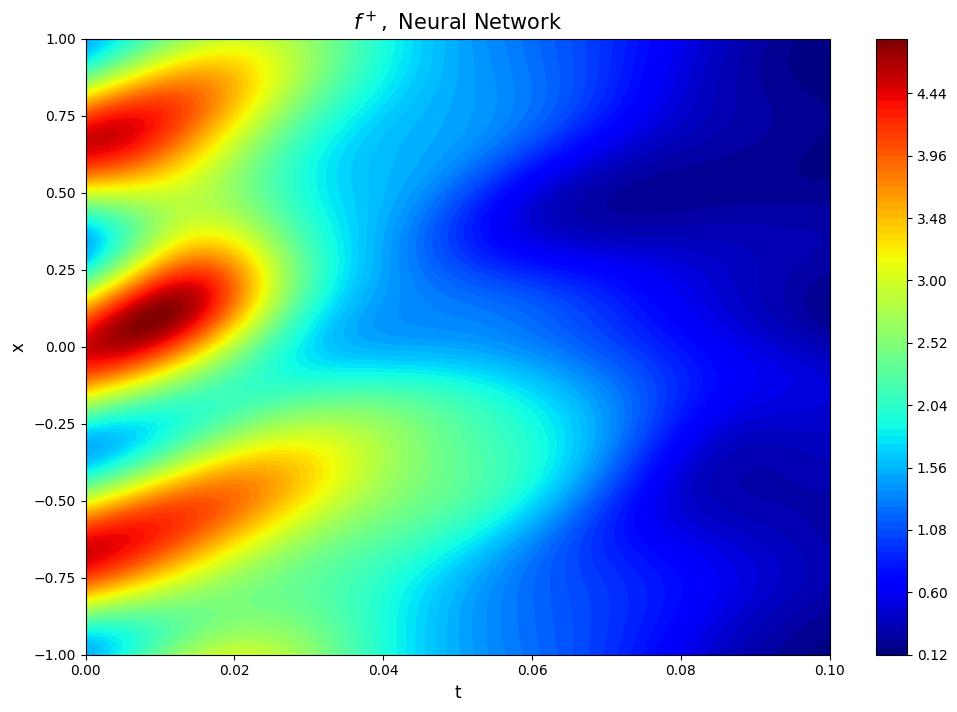

In [31]:
pred_f_plus = (preds_dict["f_plus"]).numpy()
f_plus_nn = pred_f_plus.reshape((m+1,n+1))
# f plus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_plus_nn, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^+,$ Neural Network',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_plus_nn.jpg', dpi=300)

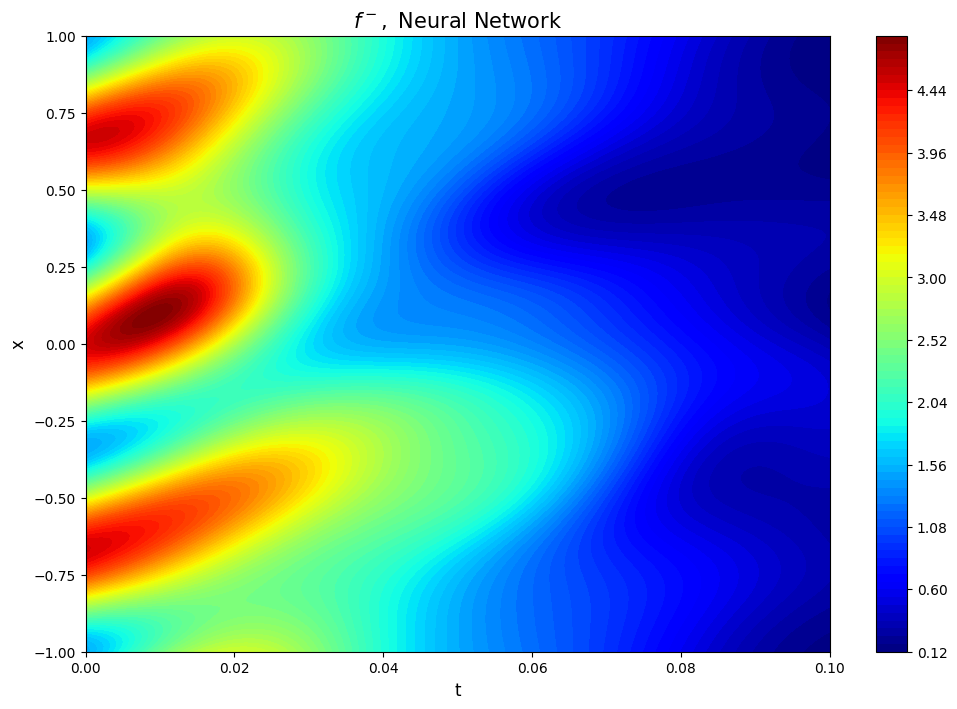

In [32]:
pred_f_minus = (preds_dict["f_minus"]).numpy()
f_minus_nn = pred_f_minus.reshape((m+1,n+1))
# f minus
fig=plt.figure(figsize=(12,8), dpi= 100)
plt.contourf(T, X, f_minus_nn, 80, cmap='jet')
plt.colorbar()
plt.title(r'$f^-,$ Neural Network',      
          fontsize="15", wrap=True)
plt.xlabel(r't', fontsize="12")
plt.ylabel(r'x', fontsize="12")  
plt.show()
fig.savefig('G_T_f_minus_nn.jpg', dpi=300)

In [33]:
from numpy.linalg import norm

In [34]:
diff_f_plus = (f_plus_tot-f_plus_nn)
diff_f_minus = (f_minus_tot-f_minus_nn)
l2_f_plus = norm(diff_f_plus, axis = 0)
l2_f_minus = norm(diff_f_minus, axis = 0)

In [35]:
np.mean(l2_f_plus)

31.83997320733427

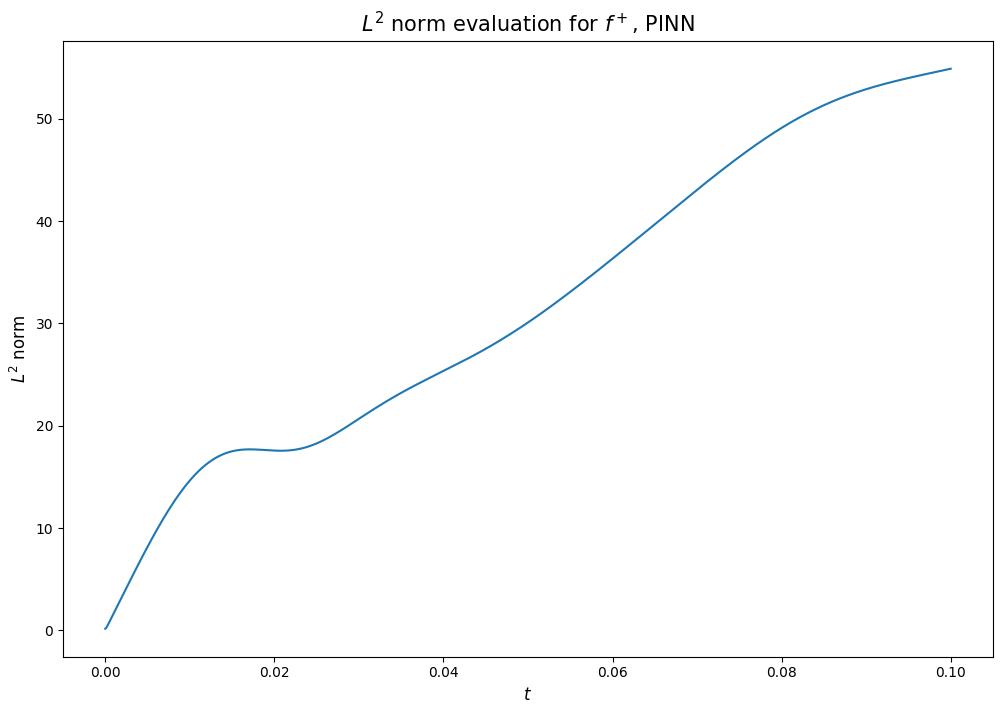

In [36]:
fig=plt.figure(figsize=(12,8), dpi= 100)

plt.plot(t_disc, l2_f_plus)
plt.title(r'$L^2$ norm evaluation for $f^+$, PINN',      
          fontsize="15", wrap=True)
plt.xlabel(r'$t$', fontsize="12")
plt.ylabel(r'$L^2$ norm', fontsize="12")  
plt.show()
fig.savefig('L2_f_plus.jpg', dpi=300)

In [37]:
np.mean(l2_f_minus)

31.839142264429157

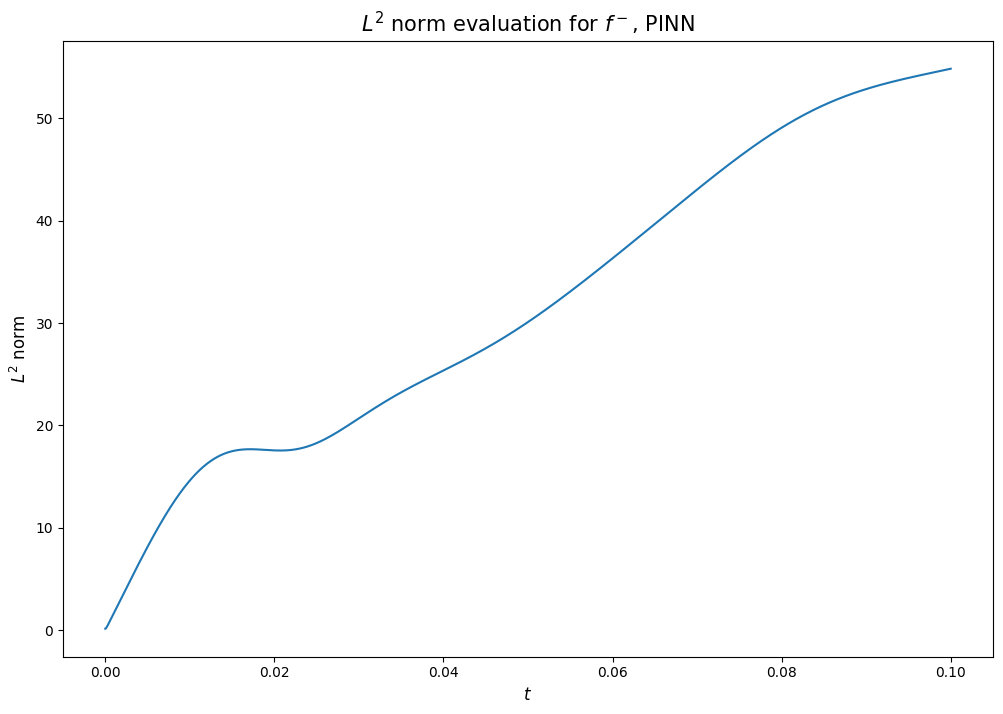

In [38]:
fig=plt.figure(figsize=(12,8), dpi= 100)

plt.plot(t_disc, l2_f_minus)
plt.title(r'$L^2$ norm evaluation for $f^-$, PINN',      
          fontsize="15", wrap=True)
plt.xlabel(r'$t$', fontsize="12")
plt.ylabel(r'$L^2$ norm', fontsize="12")  
plt.show()
fig.savefig('L2_f_minus.jpg', dpi=300)